In [1]:
import FinancialMachineLearning as fml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet('./Data/IVE_tickbidask.parq')
df

,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,300,15225.00
...,...,...,...,...,...,...
2018-10-05 15:59:59,116.20,116.18,116.19,2000,2000,232400.00
2018-10-05 15:59:59,116.20,116.18,116.19,3900,3900,453180.00
2018-10-05 16:00:00,116.22,116.20,116.21,42884,42884,4983978.48


In [3]:
mad = fml.madOutlier(df.price.values.reshape(-1, 1))
df = df.loc[~mad]
df

86.96
[36.17 36.25 36.21 ... 29.26 29.26 29.26]
[1.41225268 1.41537627 1.41381447 ... 1.14245268 1.14245268 1.14245268]


,price,bid,ask,size,v,dv
dates,,,,,,
2009-09-28 09:30:00,50.79,50.70,50.79,100,100,5079.00
2009-09-28 09:30:00,50.71,50.70,50.79,638,638,32352.98
2009-09-28 09:31:32,50.75,50.75,50.76,100,100,5075.00
2009-09-28 09:31:33,50.75,50.72,50.75,100,100,5075.00
2009-09-28 09:31:50,50.75,50.73,50.76,300,300,15225.00
...,...,...,...,...,...,...
2018-10-05 15:59:59,116.20,116.18,116.19,2000,2000,232400.00
2018-10-05 15:59:59,116.20,116.18,116.19,3900,3900,453180.00
2018-10-05 16:00:00,116.22,116.20,116.21,42884,42884,4983978.48


### Chapter 4. Sample Weights

#### Exercise 1
3장에서 t1을 최초로 Barrier가 도달한 timestamp의 pandas.Series라고 했다. 이는 getEvents 함수의 출력값이었다.

**(a)** E-mini S&P 500 future tick data에서 도출된 달러 바에 대한 t1 series를 계산하라

In [5]:
dollar_M = 1000000
dollar_df = fml.BarSampling(df, 'dv', dollar_M)
dollar_df = dollar_df.groupby(level = 0).first()
dailyVol = fml.getDailyVolatility(dollar_df.price) # Volatility
threshold = 1.65 * dailyVol.std() + dailyVol.mean()
cusum = fml.CusumEvents(dollar_df.price, threshold) # CUSUM filter
tEvents = dollar_df.iloc[cusum].index # Event 시작과 끝
t1 = fml.addVerticalBarrier(tEvents, dollar_df.price, numDays = 1) # Vertical Barrier
t1

dates
2009-09-28 09:53:49   2009-09-29 09:59:21
2009-09-28 10:02:52   2009-09-29 10:04:46
2009-09-28 10:10:21   2009-09-29 10:31:39
2009-09-28 10:19:36   2009-09-29 10:31:39
2009-09-28 10:24:23   2009-09-29 10:31:39
                              ...        
2018-10-04 15:31:17   2018-10-05 15:33:58
2018-10-04 15:41:04   2018-10-05 15:45:00
2018-10-04 15:47:18   2018-10-05 15:48:02
2018-10-04 15:51:37   2018-10-05 15:53:55
2018-10-04 16:00:00   2018-10-05 16:00:00
Name: dates, Length: 41737, dtype: datetime64[ns]

**(b)** 함수 mpNumCoEvents를 적용해 각 시간 포인트에 대해 중첩된 결과의 개수를 계산하라

In [6]:
import platform
from multiprocessing import cpu_count
if platform.system() == 'Windows':
    cpus = 1
else:
    cpus = cpu_count() - 1
minRet = 0.001
ptSl = [1, 1]
events = fml.getEvents(dollar_df.price, tEvents, ptSl, dailyVol, minRet, 1, t1 = t1)
numCoEvents = fml.mpPandasObj(fml.getConcurrentBar, ('molecule', events.index), cpus,
                              closeIdx = dollar_df.price.index, t1 = events['t1'])

2023-05-07 02:29:22.190204 100.0% getConcurrentBar done after 0.15 minutes. Remaining 0.0 minutes..


<AxesSubplot:>

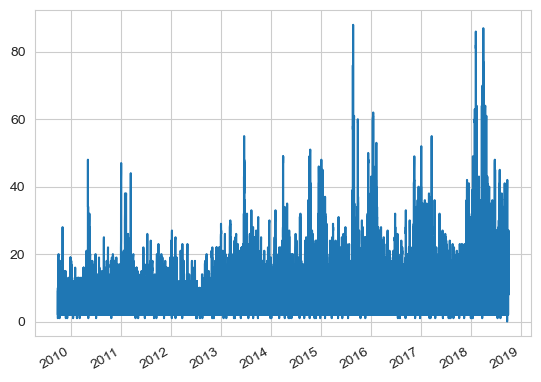

In [7]:
numCoEvents.plot()

**(c)** 주 축에서 공존하는 Label의 개수의 시계열을 도식화하고, 보조 축에서 수익률의 지수 가중 이동 표준 편사의 시계열을 도식화 하라

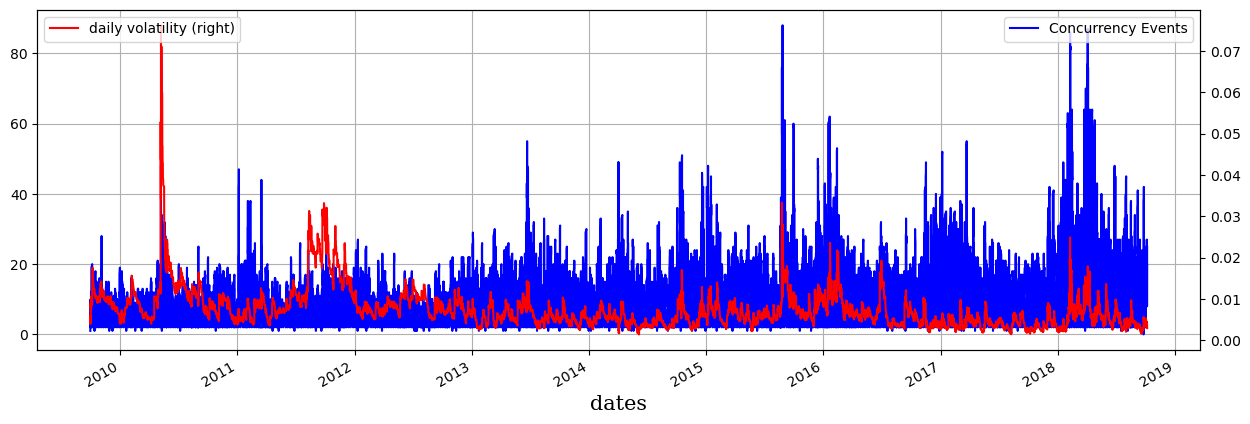

In [35]:
plt.figure(figsize = (15,5))
plt.xlabel('Time', fontfamily = 'Serif', fontsize = 15)

plt.style.use('default')
ax1 = numCoEvents.plot(color = 'blue', grid = True, label = 'Concurrency Events')
ax2 = dailyVol.plot(color = 'red', grid = True, secondary_y = True, label = 'daily volatility')

ax1.legend(loc = 1)
ax2.legend(loc = 2)

Concurrency와 Volatility는 어느정도 상관성이 있어 보인다. 실제로 그럴까?

In [28]:
import statsmodels.api as sm
X = numCoEvents.groupby(level = 0).first().values
X = sm.add_constant(X)
y = dailyVol.dropna().values
model = sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1329.
Date:                Sun, 07 May 2023   Prob (F-statistic):          3.11e-287
Time:                        02:38:55   Log-Likelihood:             1.9534e+05
No. Observations:               49968   AIC:                        -3.907e+05
Df Residuals:                   49966   BIC:                        -3.907e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062   3.87e-05    159.838      0.000       0.006       0.006
x1          7.242e-05   1.99e-06     36.458      0.000    6.85e-05    7.63e-05
==============================================================================
Omnibus:                    41889.234   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1931634.172
Skew:                           3.786   Prob(JB):                         0.00
Kurtosis:                      32.503   Cond. No.                         34.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**(d)** Concurrent Label의 개수와 수익률의 지수 가중 이동 표준 편차의 scatter plot을 그려 보라. 그 관계를 이해할 수 있겠는가?

In [43]:
coEvents = numCoEvents.to_frame()
ewmasd = dailyVol.to_frame()
combine = ewmasd.join(coEvents, how = 'inner')
combine.columns = ['ewmasd', 'coEvents']
combine['ewmasd_std'] = (combine['ewmasd']-combine['ewmasd'].mean())/combine['ewmasd'].std()
combine['coEvents_std'] = (combine['coEvents']-combine['coEvents'].mean())/combine['coEvents'].std()

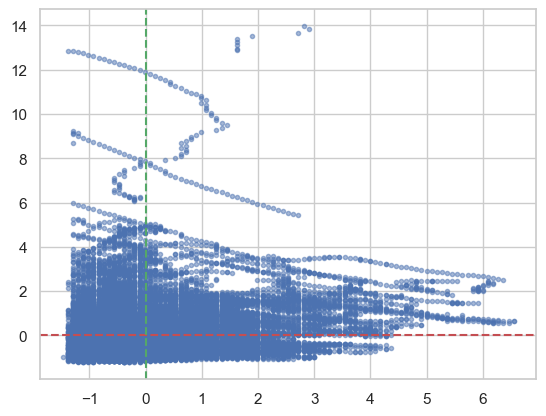

In [41]:
sns.set_style('whitegrid')
plt.scatter(combine['coEvents_std'], combine['ewmasd_std'], marker = '.', alpha = 0.5)
plt.axhline(y = combine['coEvents_std'].mean(), c='r', ls='--')
plt.axvline(x = combine['ewmasd_std'].mean(), c='g', ls='--')
plt.show()

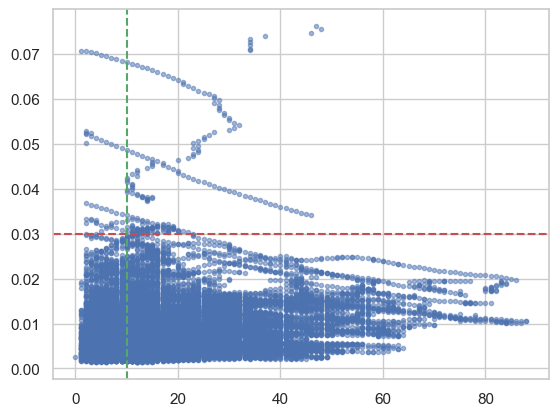

In [42]:
plt.scatter(combine['coEvents'], combine['ewmasd'], marker = '.', alpha = 0.5)
plt.axhline(y = 0.03, c='r', ls='--')
plt.axvline(x = 10, c='g', ls='--')
plt.show()

#### Exercise 2
함수 mpSampleTW를 사용해 각 Label의 평균 고유도를 계산하라. 이 시계열의 1차 자기 상관관계 $\mathbf{AR(1)}$은 무엇인가? 이는 통계적으로 유의한가? 그 이유는 무엇인가?

In [47]:
sampleTW = fml.mpSampleWeights(close = dollar_df.price, events = events, numThreads = cpus)
sampleTW

2023-05-07 02:48:52.882768 100.0% getConcurrentBar done after 0.22 minutes. Remaining 0.0 minutes..
2023-05-07 02:49:03.452871 100.0% getAvgLabelUniq done after 0.13 minutes. Remaining 0.0 minutes..


,t1,tW
dates,,
2009-09-29 10:04:46,2009-09-30 09:56:31,0.257625
2009-09-29 10:31:39,2009-09-29 12:00:17,0.320833
2009-09-29 10:52:23,2009-09-30 09:44:47,0.173341
2009-09-29 11:34:53,2009-09-30 09:44:47,0.157341
2009-09-29 12:00:17,2009-09-29 13:30:07,0.188889
...,...,...
2018-10-05 15:53:55,2018-10-05 16:00:00,0.043829
2018-10-05 15:56:25,2018-10-05 16:00:00,0.043287
2018-10-05 15:58:23,2018-10-05 16:00:00,0.042420


In [48]:
import statsmodels.tsa as tsa
ar = tsa.arima.model.ARIMA(sampleTW['tW'], order = (1,0,0))
result = ar.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     tW   No. Observations:                41751
Model:                 ARIMA(1, 0, 0)   Log Likelihood              100868.909
Date:                Sun, 07 May 2023   AIC                        -201731.817
Time:                        02:49:17   BIC                        -201705.899
Sample:                             0   HQIC                       -201723.630
                              - 41751                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0766      0.002     49.774      0.000       0.074       0.080
ar.L1          0.8778      0.001    637.386      0.000       0.875       0.880
sigma2         0.0005   9.07e-07    514.471      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   6.37   Jarque-Bera (JB):           7711836.58
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                             4.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        68.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

$\mathbf{AR(1)}$ model 확인 결과, 1차 자기회귀항의 $\mathrm{p-value}$는 0에 가깝다

Text(0.5, 1.0, 'Residual vs. Normal')

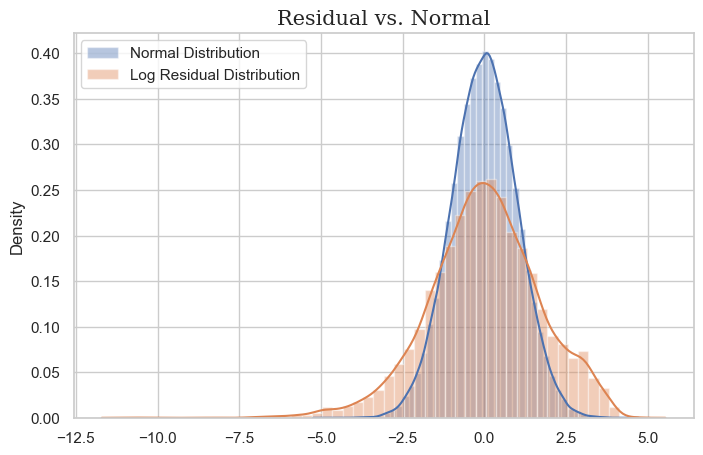

In [49]:
fig, ax1 = plt.subplots(figsize=(8,5), dpi = 100)
sns.distplot(np.random.normal(size = 100000), kde = True, ax = ax1, label = 'Normal Distribution')
sns.distplot(np.log(result.resid) - np.log(result.resid).mean() ,
             kde = True, rug = False , ax = ax1, label = 'Log Residual Distribution')
plt.legend()
plt.title('Residual vs. Normal', fontsize = 15, fontfamily = 'Serif')

<AxesSubplot:xlabel='dates'>

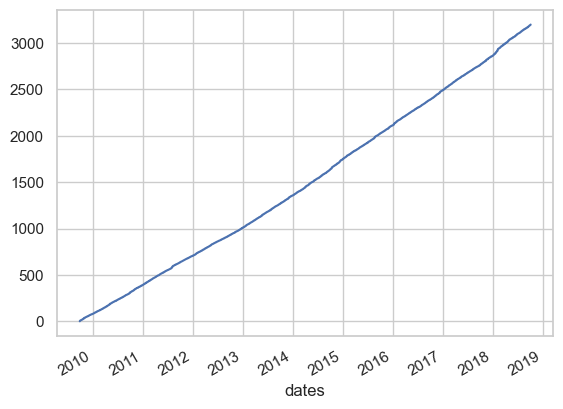

In [52]:
sampleTW['tW'].cumsum().plot()

잔차에 대해서도 정규분포보다는 첨도가 더 낮긴 하지만 충분히 안정적인 양상을 띄고 있고, 누적합 그래프에 대해서도 안정적인 상승 추세선인 것을 보아 통계적으로 유의하다고 볼 수 있다

#### Exercise 3
Random Forest를 $I^{-1} \sum_{i=1}^{I} \bar{u_i} ≪ 1$과 같은 금융 데이터셋에 적합화하라

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_curve, classification_report
from sklearn.preprocessing import StandardScaler

In [66]:
Xy = (pd.DataFrame().assign(close = dollar_df.price, close_lag = dollar_df.price.shift(1))).dropna()

y = Xy.loc[:,'close'].values
X = Xy.loc[:,'close_lag'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,
                                                    shuffle=False)

n_estimator = 100
rf = RandomForestRegressor(max_depth = 2, n_estimators = n_estimator, criterion = 'squared_error', oob_score = True, random_state = 42)

In [67]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, oob_score=True, random_state=42)

**(a)** OOB 정확도 평균은 얼마인가?

In [68]:
print('The Accuracy of OOB score is', rf.oob_score_)

The Accuracy of OOB score is 0.9318986650528569


**(b)** 동일한 Data Set에 대한 K-Fold Cross Validation의 평균 정확도는 얼마인가?

In [69]:
from sklearn.model_selection import cross_validate

n_estimator = 100
rf = RandomForestRegressor(max_depth = 2, n_estimators = n_estimator, criterion = 'squared_error', oob_score = True, random_state = 42)

scores = cross_validate(rf, X, y, cv = 5, return_estimator = True)

In [70]:
oob_scores = [est.oob_score_ for est in scores['estimator']]
oob_scores, np.mean(oob_scores)

([0.9213249356834171,
  0.9580283515244505,
  0.9523927961388734,
  0.9610833528003494,
  0.9294363688437512],
 0.9444531609981682)

**(c)** OOB 정확도가 Cross Validation보다 훨씬 더 높은 이유는 무엇인가? 어떤 것이 더 정확하고 어떤 것이 덜 편항되었는가? 이 편향의 원인은 무엇인가?

#### Exercise 4
4.7절의 코드를 수정해 지수 시간-감쇠 요인을 적용하라

In [71]:
def getExTimeDecay(tW, clfLastW = 1.,exponent = 1):
    clfW = tW.sort_index().cumsum()
    if clfLastW >= 0: slope = ((1.-clfLastW)/clfW.iloc[-1]) ** exponent
    else: slope = (1./((clfLastW + 1) * clfW.iloc[-1])) ** exponent
    const = 1.-slope * clfW.iloc[-1]
    clfW = const + slope * clfW
    clfW[clfW < 0] = 0
    print(round(const, 4), round(slope, 4))
    return clfW

In [76]:
out=pd.DataFrame()
out['tW'] = fml.mpPandasObj(fml.getAvgLabelUniq,('molecule', events.index),
                            cpus, t1 = events['t1'], numCoEvents = numCoEvents)
## example ##
out['w'] = fml.mpPandasObj(fml.mpSampleW, ('molecule',events.index), cpus,
                         t1 = events['t1'], numCoEvents = numCoEvents, close = dollar_df.price)
out['w'] *= out.shape[0]/out['w'].sum()

2023-05-07 03:18:06.158864 100.0% getAvgLabelUniq done after 0.11 minutes. Remaining 0.0 minutes..
2023-05-07 03:18:15.928783 100.0% mpSampleW done after 0.14 minutes. Remaining 0.0 minutes..


1.0 0.0
-1.6589 0.0008
-3.4718 0.0014
-6.5206 0.0024
-8.3316 0.0029
-11.6481 0.004


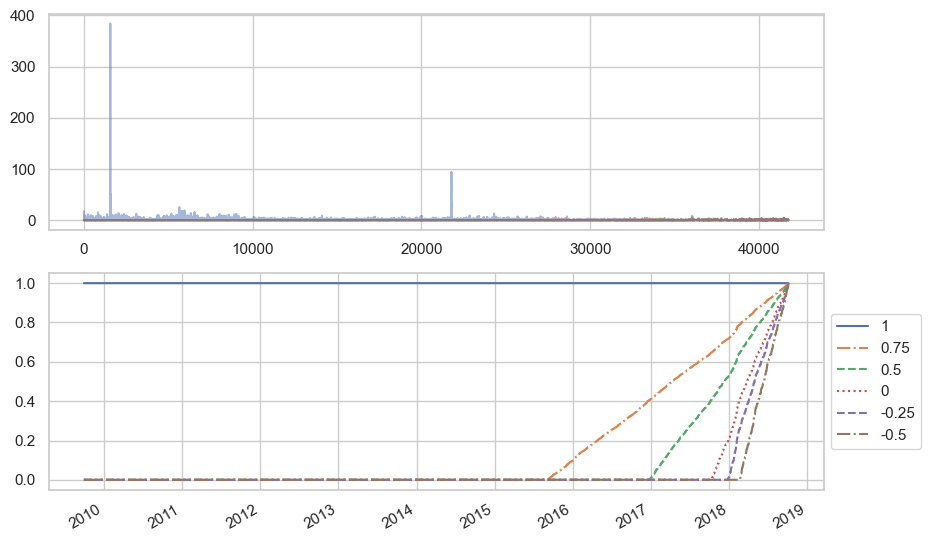

In [77]:
f,ax=plt.subplots(2,figsize=(10,7))
fs = [1,.75,.5,0,-.25,-.5]
ls = ['-','-.','--',':','--','-.']
for lstW, l in zip(fs,ls):
    decayFactor = getExTimeDecay(out['tW'].dropna(),
                                 clfLastW=lstW,
                                 exponent=0.75) # experiment by changing exponent
    ((out['w'].dropna()*decayFactor).reset_index(drop=True)
     .plot(ax=ax[0],alpha=0.5))
    s = (pd.Series(1,index=out['w'].dropna().index)*decayFactor)
    s.plot(ax=ax[1], ls=l, label=str(lstW))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### Exercise 5
Meta-Label을 추세 조종 모델에 의해 결정된 이벤트에 적용했다고 가정해 보자. Label의 $\frac{2}{3}$가 0이고, $\frac{1}{3}$이 1이라고 가정해 보자

**(a)** Class Weight를 Balanced하지 않고, 분류기를 적합화하면 어떤 일이 발생하는가?

**(b)** Label 1은 True positived이고, Label 0는 False positive이다. Balanced class weights를 적용해 분류기가 True positive에 더 집중하도록 강제하고, False positive에 덜 집중하도록 강제화한다. 이 작업이 왜 의미가 있는가?

**(c)** Balanced class weighs를 적용하기 전과 후의 prediced label distribution은 무엇인가?